### Goal
- prepare stats data for machine learning

### Steps
- : review dtypes,and prepare continuous numeric, discrete numeric, categorical, character and identity columns
Input: nfl_weekly_stats.parquet
Work:
    - separate continuous numeric, discrete numeric, categorical, character and identity columns
    - label encode
    - merge all back together
Output:
    - nfl_ml_weekly_stats.parquet - cleaned, labeled data

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../src"))


In [2]:
from src import *


In [3]:
logger = configs.configure_logging("pbp_logger")
logger.setLevel(logging.INFO)

# <font color=teal>offense stats<font/>


### <font color="#9370DB">load and transform weekly offense stats</font>
- load the weekly dataset
- train xgboost feature model
- choose best features
- calculate the weighted averages of features into a 'power' score

In [5]:
from src.nfl_03_perform_feature_selection import SelectNFLFeatures

F = SelectNFLFeatures("offense")
F.get_best_features()
F.calculate_and_add_power_score()
F.input_stats.head()

2023-07-19 20:23:59,669 - INFO - SelectNFLFeatures
2023-07-19 20:23:59,670 - INFO - load tmp_weekly_offense
2023-07-19 20:23:59,676 - INFO - prepare a features dataset
2023-07-19 20:23:59,676 - INFO - encode the target win/loss column
2023-07-19 20:23:59,678 - INFO - create a features dataframe for feature selection ...
2023-07-19 20:23:59,678 - INFO - scale all features  ...
2023-07-19 20:24:00,595 - INFO - get percentage contribution of offensive and defensive features
2023-07-19 20:24:00,598 - INFO - calculate weighted average of offensive and defensive features


,team,season,week,passing_air_yards,receiving_yards,passing_epa,avg_receiving_epa,carries,passing_tds,passing_yards_after_catch,...,team_score,team_coach,opposing_team,opposing_score,opposing_coach,spread,count,win,target,offense_power
index,,,,,,,,,,,,,,,,,,,,,
0,ARI,2016,1,372.0,271.0,0.829865,1.247254,19.0,2.0,105.0,...,21,Bruce Arians,NE,23,Bill Belichick,-2.0,1,loss,0,27.537980
1,ARI,2016,2,379.0,315.0,1.126585,1.222671,30.0,3.0,157.0,...,40,Bruce Arians,TB,7,Dirk Koetter,33.0,1,win,1,31.141795
2,ARI,2016,3,558.0,287.0,-1.008722,-0.745092,22.0,0.0,90.0,...,18,Bruce Arians,BUF,33,Rex Ryan,-15.0,1,loss,0,27.300136
3,ARI,2016,4,472.0,325.0,-0.389266,0.461687,25.0,1.0,116.0,...,13,Bruce Arians,LA,17,Jeff Fisher,-4.0,1,loss,0,29.620453
4,ARI,2016,5,340.0,124.0,-0.544776,-0.390593,37.0,2.0,49.0,...,33,Bruce Arians,SF,21,Chip Kelly,12.0,1,win,1,26.263685


### <font color="#9370DB">review weekly offense features</font>

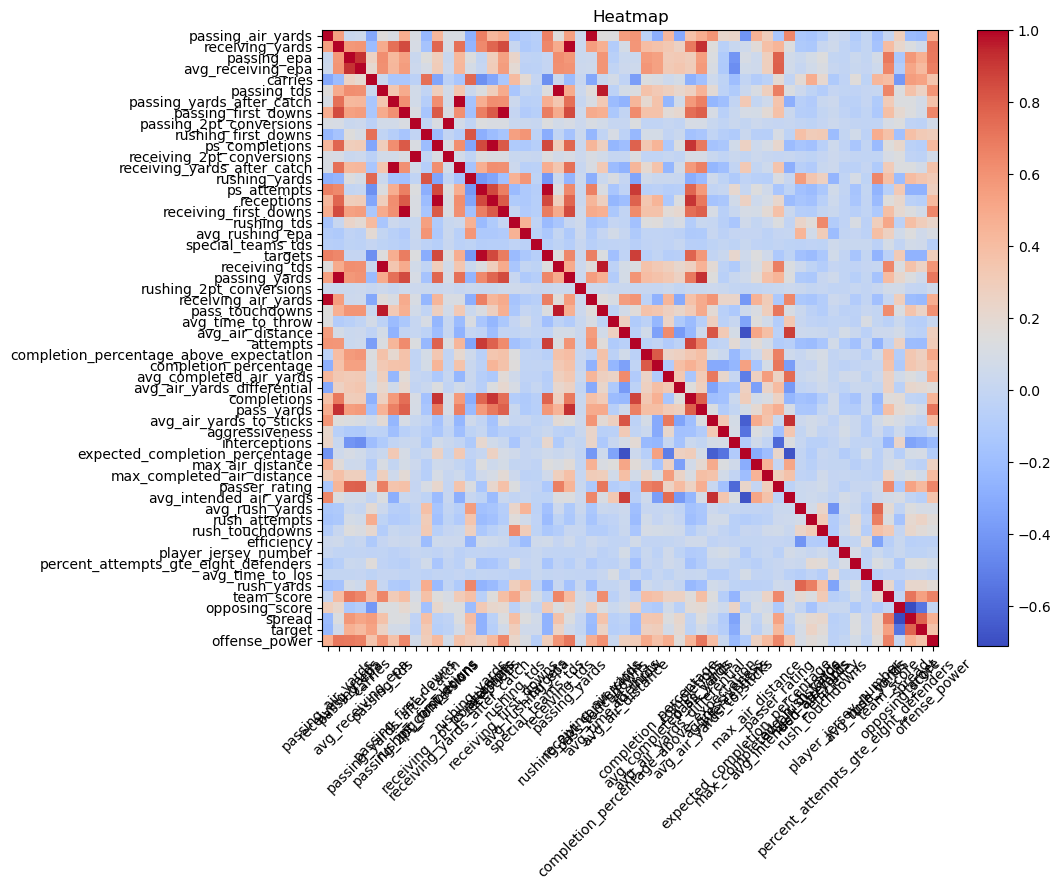

/Users/christopherlomeli/Source/courses/datascience/Springboard/capstone/NFL/NFLVersReader/src/nfl_03_perform_defense_feature_selection.py:77: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


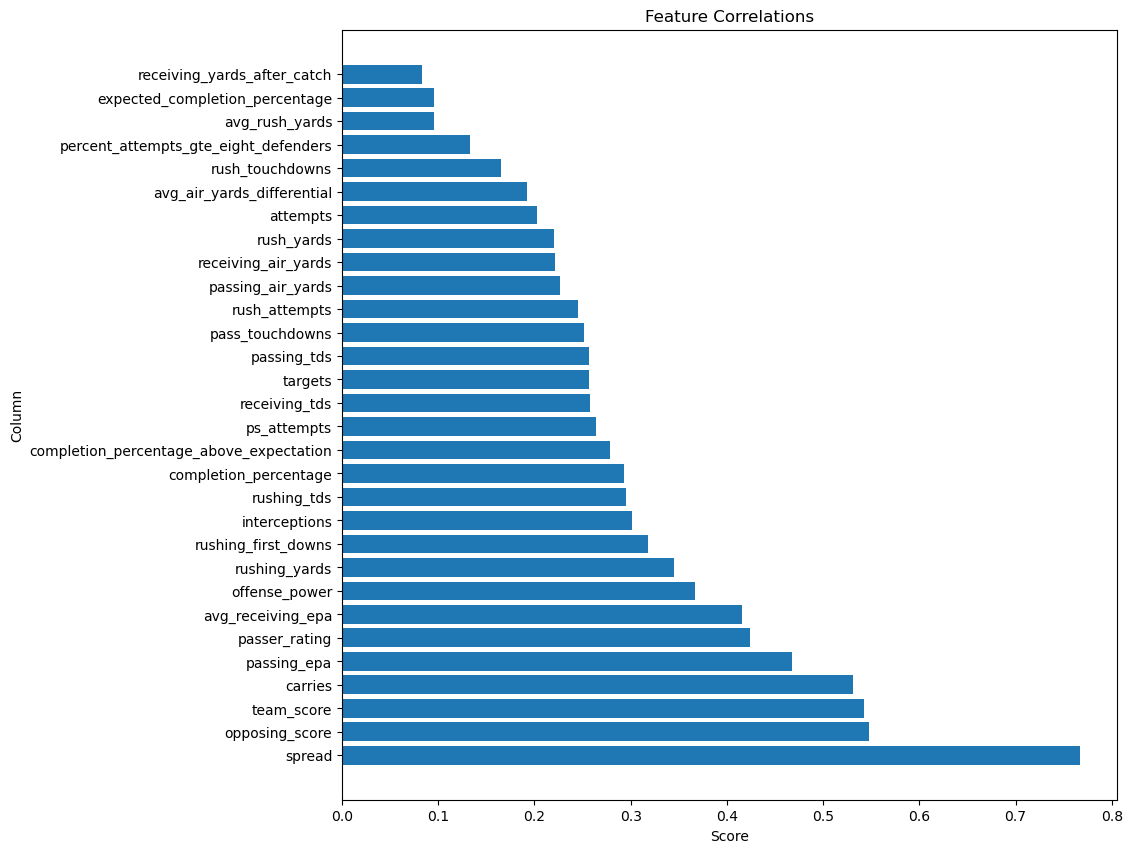

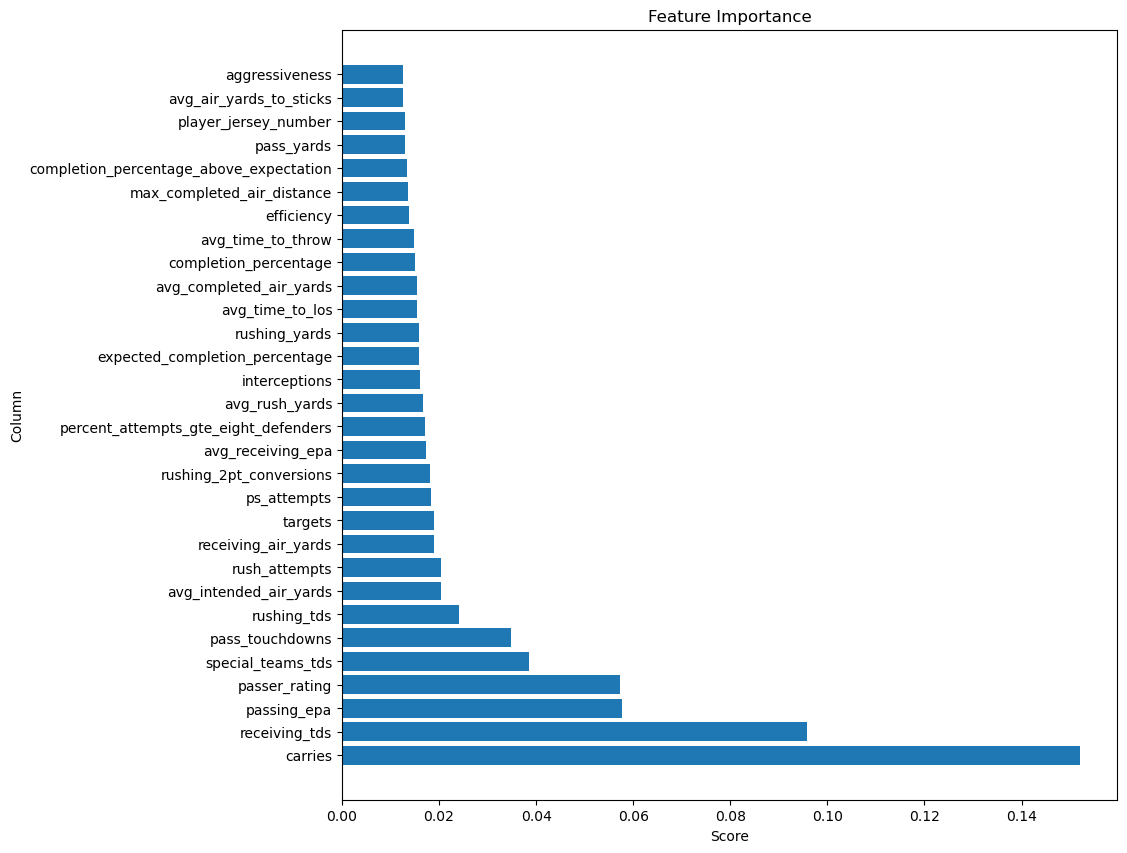

In [11]:
F.show_heatmap()
F.show_correlations()
F.plot_best_features()

# <font color=teal>defense stats<font/>

### <font color="#9370DB">load and transform weekly defense stats</font>
- load the weekly dataset
- train xgboost feature model
- choose best features
- calculate the weighted averages of features into a 'power' score

In [6]:
D = SelectNFLFeatures("defense")
D.get_best_features()
D.calculate_and_add_power_score()
D.input_stats.head()

2023-07-19 20:24:07,869 - INFO - SelectNFLFeatures
2023-07-19 20:24:07,869 - INFO - load tmp_weekly_defense
2023-07-19 20:24:07,873 - INFO - prepare a features dataset
2023-07-19 20:24:07,873 - INFO - encode the target win/loss column
2023-07-19 20:24:07,874 - INFO - create a features dataframe for feature selection ...
2023-07-19 20:24:07,874 - INFO - scale all features  ...
2023-07-19 20:24:08,610 - INFO - get percentage contribution of offensive and defensive features
2023-07-19 20:24:08,613 - INFO - calculate weighted average of offensive and defensive features


,team,season,week,sack_fumbles,rushing_fumbles,sack_yards,sacks,ps_interceptions,sack_fumbles_lost,receiving_fumbles,...,team_score,team_coach,opposing_team,opposing_score,opposing_coach,spread,count,win,target,defense_power
index,,,,,,,,,,,,,,,,,,,,,
0,ARI,2016,1,0.0,1.0,19.0,3.0,0.0,0.0,0.0,...,21,Bruce Arians,NE,23,Bill Belichick,-2.0,1,loss,0,5.682754
1,ARI,2016,2,0.0,0.0,4.0,1.0,0.0,0.0,0.0,...,40,Bruce Arians,TB,7,Dirk Koetter,33.0,1,win,1,5.134865
2,ARI,2016,3,2.0,1.0,27.0,5.0,4.0,0.0,0.0,...,18,Bruce Arians,BUF,33,Rex Ryan,-15.0,1,loss,0,7.516790
3,ARI,2016,4,1.0,1.0,23.0,3.0,3.0,1.0,0.0,...,13,Bruce Arians,LA,17,Jeff Fisher,-4.0,1,loss,0,5.518707
4,ARI,2016,5,0.0,1.0,8.0,1.0,0.0,0.0,0.0,...,33,Bruce Arians,SF,21,Chip Kelly,12.0,1,win,1,7.078992


### <font color="#9370DB">review weekly defense features</font>


- train xgboost feature model

- concat a weighted average "power" score to the stats dataset

### save the dataset

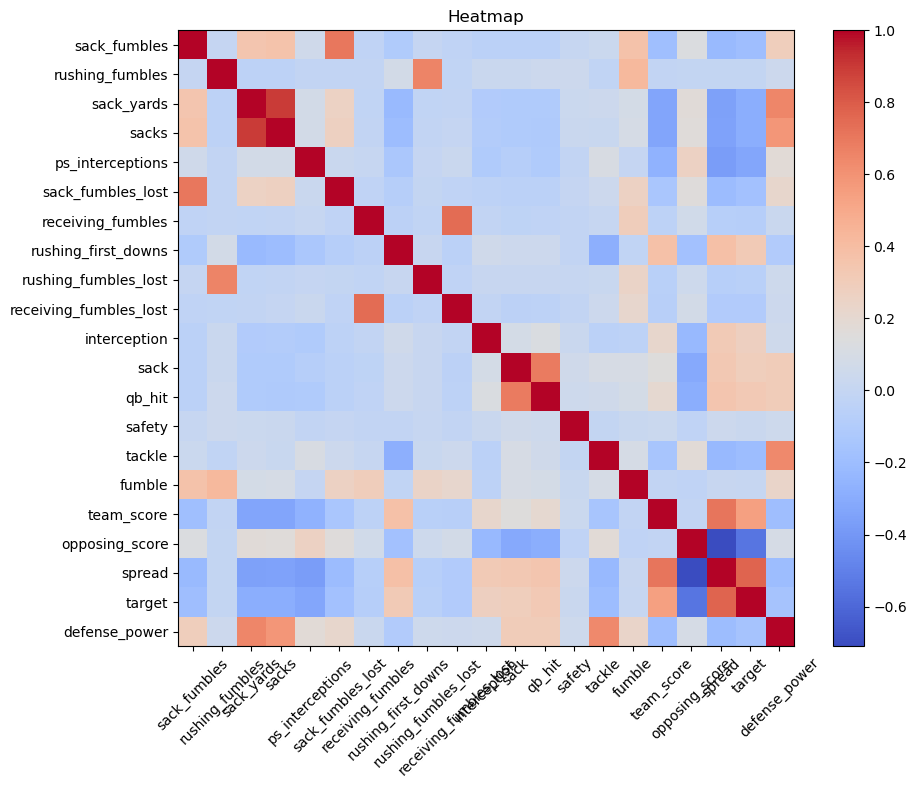

/Users/christopherlomeli/Source/courses/datascience/Springboard/capstone/NFL/NFLVersReader/src/nfl_03_perform_defense_feature_selection.py:77: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


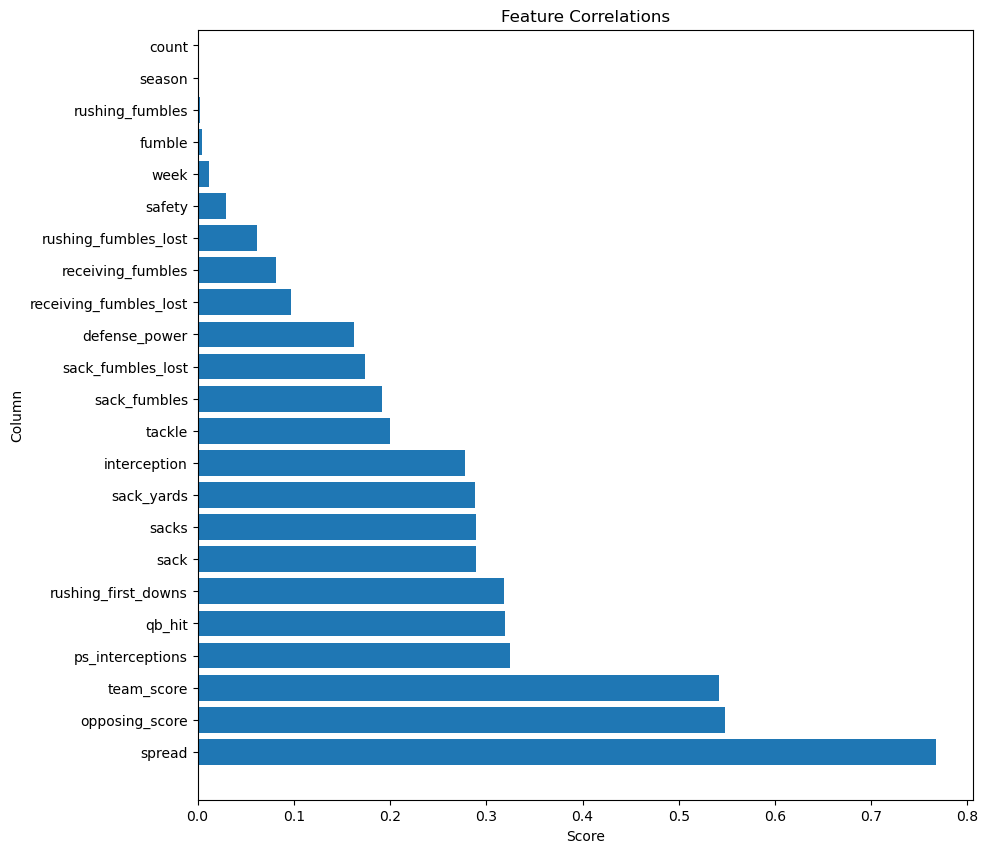

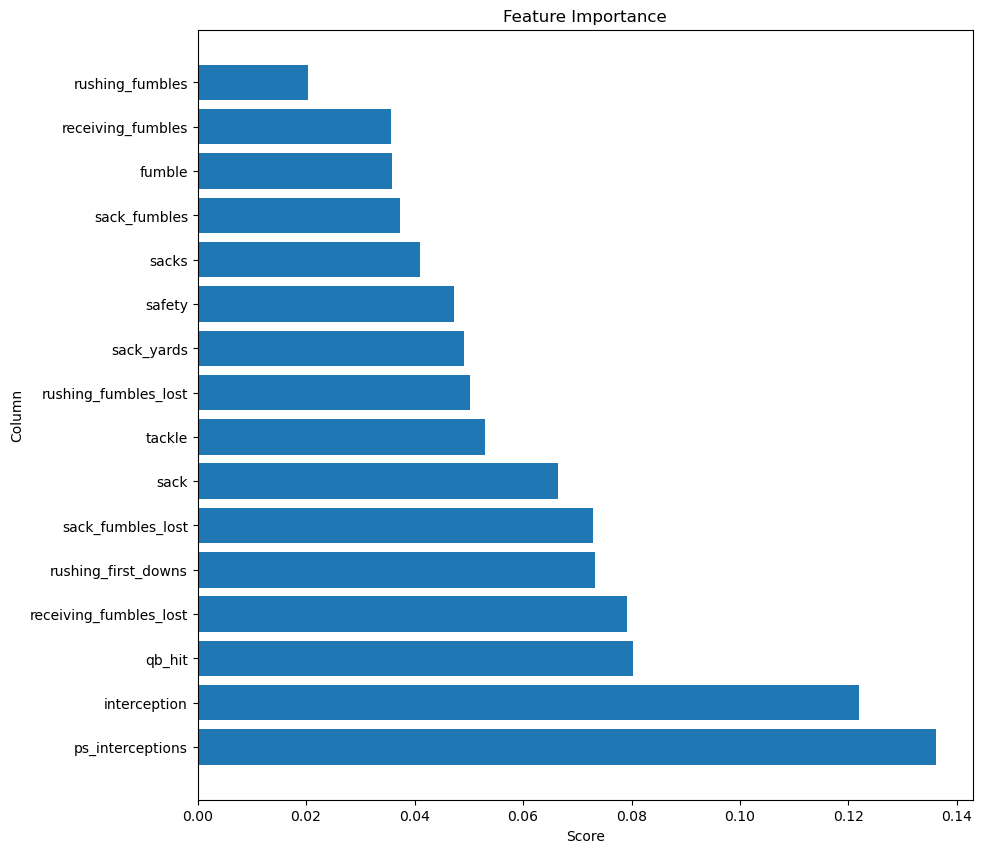

CPU times: user 969 ms, sys: 35.2 ms, total: 1 s
Wall time: 375 ms


In [10]:
%%time
D.show_heatmap()
D.show_correlations()
D.plot_best_features()

# <font color=teal>Store offense and defense features<font/>

In [12]:
F.write_output()
D.write_output()